# Исследование сервиса аренды самокатов GoFast

**Описание проекта:**  
Проект подразумевает анализ данных для сервиса аренды самокатов **GoFast**. Основная цель проекта — исследовать данные о пользователях и их поездках для проверки гипотез, которые могут способствовать росту бизнеса. Анализ должен сосредоточиться на подсчёте выручки, сравнении поведения пользователей с подпиской и без неё, а также проверке различных гипотез, связанных с использованием сервиса.

Ключевые задачи:

1. **Подсчёт выручки** пользователей с подпиской и без подписки на основе данных о поездках.
2. **Проверка гипотез** о том, больше ли времени на поездки тратят подписчики, и сравнение среднего расстояния поездок с порогом износа самокатов (3130 метров).
3. **Оценка**, насколько выручка от подписчиков выше, чем от обычных пользователей, и как обновление серверов влияет на количество обращений в техподдержку.
4. **Дополнительные исследования**, такие как оптимизация маркетинговых акций, чтобы повысить количество продлений подписок, а также анализ откликов на push-уведомления.

## Загрузка данных

В основных данных есть информация о пользователях, их поездках и подписках.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [ ]:
try:
    users_go = pd.read_csv('/datasets/users_go.csv')  # Для практикума
    rides_go = pd.read_csv('/datasets/rides_go.csv')
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')
except FileNotFoundError:
    try:
        users_go = pd.read_csv('../Модуль 1 спринт 1/users_go.csv')  # Если файл локальный
        rides_go = pd.read_csv('../Модуль 1 спринт 1/rides_go.csv')
        subscriptions_go = pd.read_csv('../Модуль 1 спринт 1/subscriptions_go.csv')
    except FileNotFoundError:
        try:
            users_go = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Модуль 1/Модуль 1 спринт 1/users_go.csv')  # Для Google Colab
            rides_go = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Модуль 1/Модуль 1 спринт 1/rides_go.csv')
            subscriptions_go = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Модуль 1/Модуль 1 спринт 1/subscriptions_go.csv')
        except FileNotFoundError:
            print('Файл не найден ни в одном из указанных мест.')

**Описание данных:**

<strong><u>user_go</u></strong>

* `user_id` — уникальный идентификатор пользователя
* `name` — имя пользователя
* `age` — возраст
* `city` — город
* `subscription_type` — тип подписки (free, ultra)

<strong><u>rides_go</u></strong>

* `user_id` —	уникальный идентификатор пользователя
* `distance` —	расстояние, которое пользователь проехал в текущей сессии (в метрах)
* `duration` —	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* `date` —	дата совершения поездки

<strong><u>subscriptions_go</u></strong>

* `subscription_type` —	тип подписки
* `minute_price` —	стоимость одной минуты поездки по данной подписке
* `start_ride_price` —	стоимость начала поездки
* `subscription_fee` —	стоимость ежемесячного платежа

Изучим дата фреймы

In [3]:
print('данные о пользователях')
display(users_go.head(10))
display(users_go.tail(10))

print()
print('данные о поездках')
display(rides_go.head(10))
display(rides_go.tail(10))

print()
print('данные о подписках')
subscriptions_go

данные о пользователях


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


,user_id,name,age,city,subscription_type
1555,72,Никита,25,Москва,ultra
1556,422,Кирилл,27,Сочи,ultra
1557,611,Владимир,28,Омск,ultra
1558,1237,Евгения,23,Тюмень,free
1559,209,Андрей,23,Омск,ultra
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra
1564,1045,Артемий,28,Ростов-на-Дону,free



данные о поездках


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


,user_id,distance,duration,date
18058,1534,195.447469,6.469074,2021-06-11
18059,1534,3214.021065,18.343604,2021-06-18
18060,1534,3644.708038,20.289416,2021-08-08
18061,1534,3977.744996,26.916544,2021-08-20
18062,1534,4928.173852,22.560373,2021-09-13
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27
18067,1534,2371.711192,15.893917,2021-12-29



данные о подписках


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
 - **без подписки**
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;


 - **с подпиской Ultra**
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

**Изучим структуру каждого датафрейма**

In [4]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Столбец date имеет формат object

In [6]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


В датафрейме отсуствуют пропуски, это радует!

**Построим диаграммы для дальнейшего изучения**

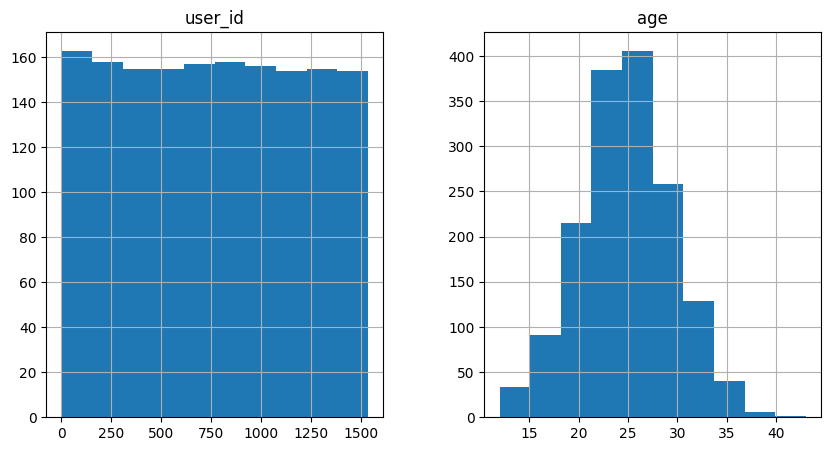

In [7]:
users_go.hist(figsize=(10, 5));

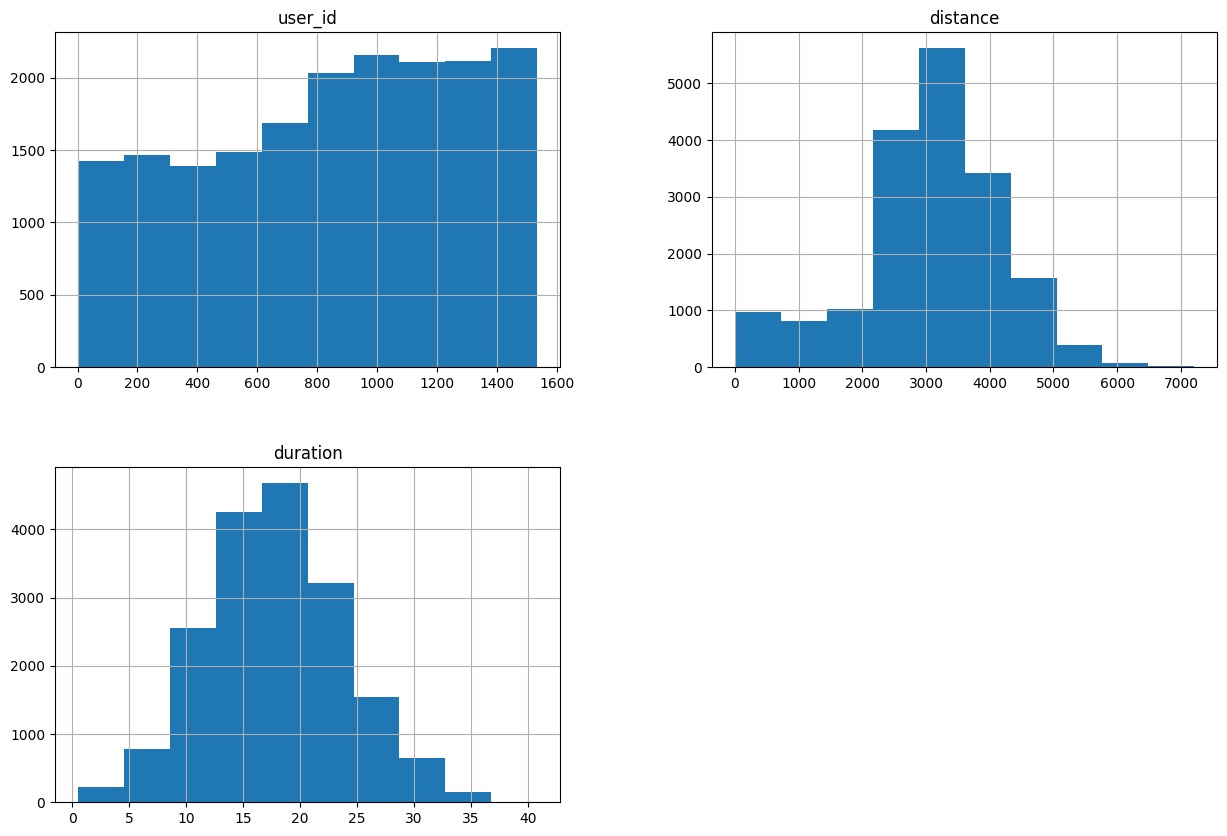

In [8]:
rides_go.hist(figsize=(15, 10));

Данные распределены нормально! Возможны незначительные выбросы

Промежуточные итоги:

 - `user_go` имеет 5 столбцов и 1565 строк;
 - `rides_go` имеет 4 столбца и 18068 строк, количество уникальных `user_id` - 1534;
 - `subscriptions_go` имеет 4 столбца и 2 строки
 - В датафреймах не обнаружены пропуски и нет явных выбросов

## Предобработка данных

**Изменим формат времени в столбце `date` из датафрейма `rides_go`**

In [9]:
# изменим формат времени в столбце date
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d') # 2021-11-04

rides_go['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

In [10]:
print(f"Диапазон в столбце date: с {rides_go['date'].min()} до {rides_go['date'].max()}")

Диапазон в столбце date: с 2021-01-01 00:00:00 до 2021-12-30 00:00:00


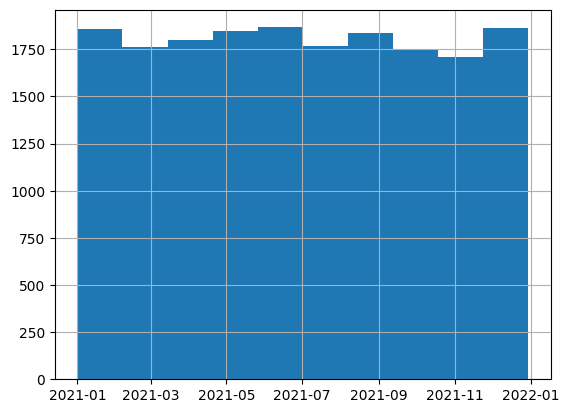

In [11]:
rides_go['date'].hist();

Данные распределены нормально

**Проверим на наличие явных дубликатов в каждом датафрейме**

In [12]:
print("Количество дубликатов в users_go:")
print(users_go.duplicated().sum())
print()

print("Количество дубликатов в rides_go:")
print(rides_go.duplicated().sum())
print()

print("Количество дубликатов в rides_go:")
print(subscriptions_go.duplicated().sum())
print()

Количество дубликатов в users_go:
31

Количество дубликатов в rides_go:
0

Количество дубликатов в rides_go:
0



In [13]:
# обработаем дубликаты
users_go[users_go.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Странно, что дубликаты расположены друг за другом в конце датафрейма

In [14]:
users_go = users_go.drop_duplicates().reset_index(drop=True)

users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.1+ KB


In [15]:
print('Количество уникальных пользователей: от ', users_go['user_id'].min(),'до ', users_go['user_id'].max())

Количество уникальных пользователей: от  1 до  1534


Количество столбцов уменьшилось, и в результате количество уникальных `user_id` в двух датафреймах — `user_go` и `rides_go` — совпало

**Создайте новый столбец с номером месяца на основе столбца `date`**

In [16]:
print(f"Диапазон в столбце date: с {rides_go['date'].min()} до {rides_go['date'].max()}")

rides_go['month'] = rides_go['date'].dt.month

Диапазон в столбце date: с 2021-01-01 00:00:00 до 2021-12-30 00:00:00


In [17]:
# Выведем результат добавления на экран
display(rides_go[['date', 'month']].head(10))

,date,month
0,2021-01-01,1
1,2021-01-18,1
2,2021-04-20,4
3,2021-08-11,8
4,2021-08-28,8
5,2021-10-09,10
6,2021-10-19,10
7,2021-11-06,11
8,2021-11-14,11
9,2021-11-22,11


Промежуточные итоги:

 - `user_go` обработаны дубликаты;
 - `rides_go` в столбце `date` изменен формат времени на datetime и добавлен новый столбец `mounth`;

## Исследовательский анализ данных

**Частота встречаемости городов**

In [18]:
# Частоту встречаемости городов найдем методом values_count()
users_go['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

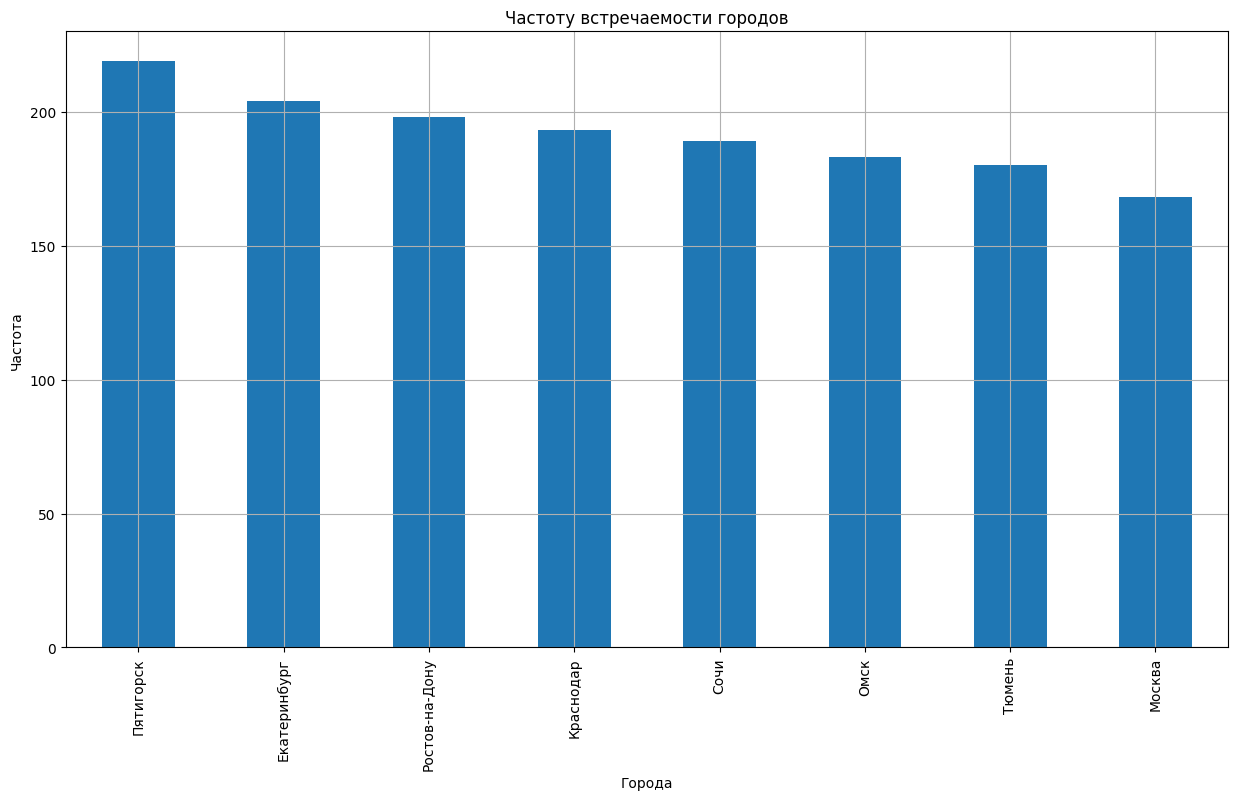

In [19]:
# Визуализируем частоту встречаемости городов
users_go['city'].value_counts().plot(
    kind='bar',
    figsize=(15, 8),
    grid=True
)

# Задание названия графика
plt.title('Частоту встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Частота')

# Показать график
plt.show()

Наиболее часто встречающийся город — Пятигорск, тогда как меньше всего "самокатчиков" наблюдается в Москве. Эти данные могут помочь бизнесу в принятии решений о том, на какие города стоит обратить внимание в зависимости от стратегии — либо сосредоточиться на удержании пользователей, либо на увеличении их количества в отдельных локациях.

**Соотношение пользователей с подпиской и без подписки**

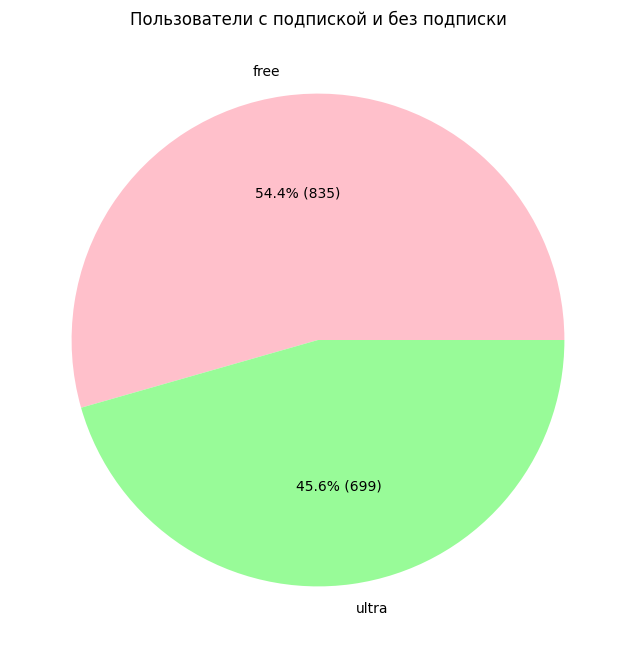

In [20]:
# частоту встречаемости типов подписки найдем методом value_counts()
users_go['subscription_type'].value_counts().plot(
    kind='pie',
    figsize=(10, 8),
    colors = ['pink', '#98FB98'],
    autopct=lambda pct: f'{pct:.1f}% ({int(pct/100.*sum(users_go["subscription_type"].value_counts()))})'
)

# Задание названия графика
plt.title('Пользователи с подпиской и без подписки')
plt.ylabel('')

# Показать график
plt.show()

Получилась стильная, а главное информативная инфографика.
Количество пользователей с подпиской `free` больше на `8,8%`. Количество пользоватлей без подпискик 835, с 699

**Возраст пользователей**

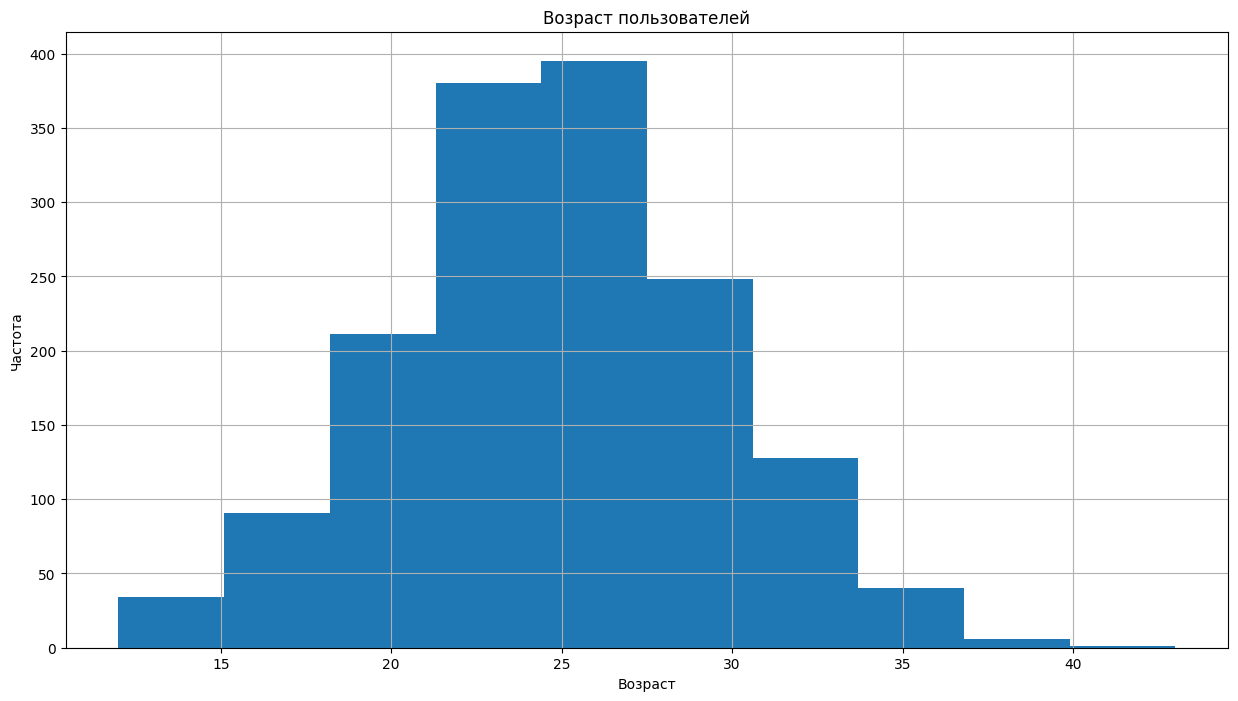

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [21]:
# Используем метод value_counts()

users_go['age'].plot(
    kind='hist',
    figsize=(15, 8),
    grid=True
)

# Задание названия графика
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')

# Показать график
plt.show()

users_go['age'].describe()

Возраст пользователей варьируется от 12 до 43 лет, при этом наиболее популярная возрастная группа — 25 лет. Целевой аудиторию можно считать пользователей от ~18, до 32.

**Расстояние, которое пользователь преодолел за одну поездку**

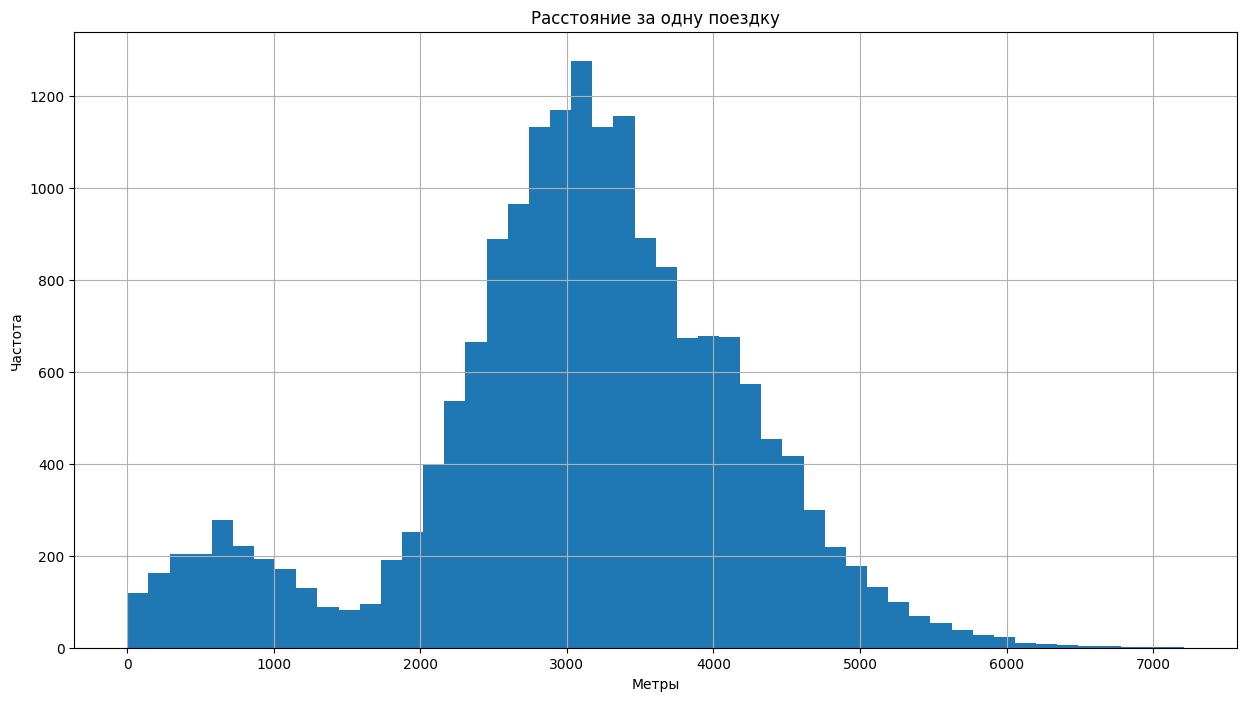

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [22]:
rides_go['distance'].plot(
    kind = 'hist',
    bins=50,
    figsize=(15, 8),
    grid=True
)

plt.title('Расстояние за одну поездку')
plt.xlabel('Метры')
plt.ylabel('Частота')

# Показать график
plt.show()

rides_go['distance'].describe()

Данные распределены нормально, с двумя пиками: от ~1 до ~1500 метров и от ~1500 до 7211 метров. Мода этих пиков составляет примерно 750 метров и 3200 метров.

**Продолжительность поездок**

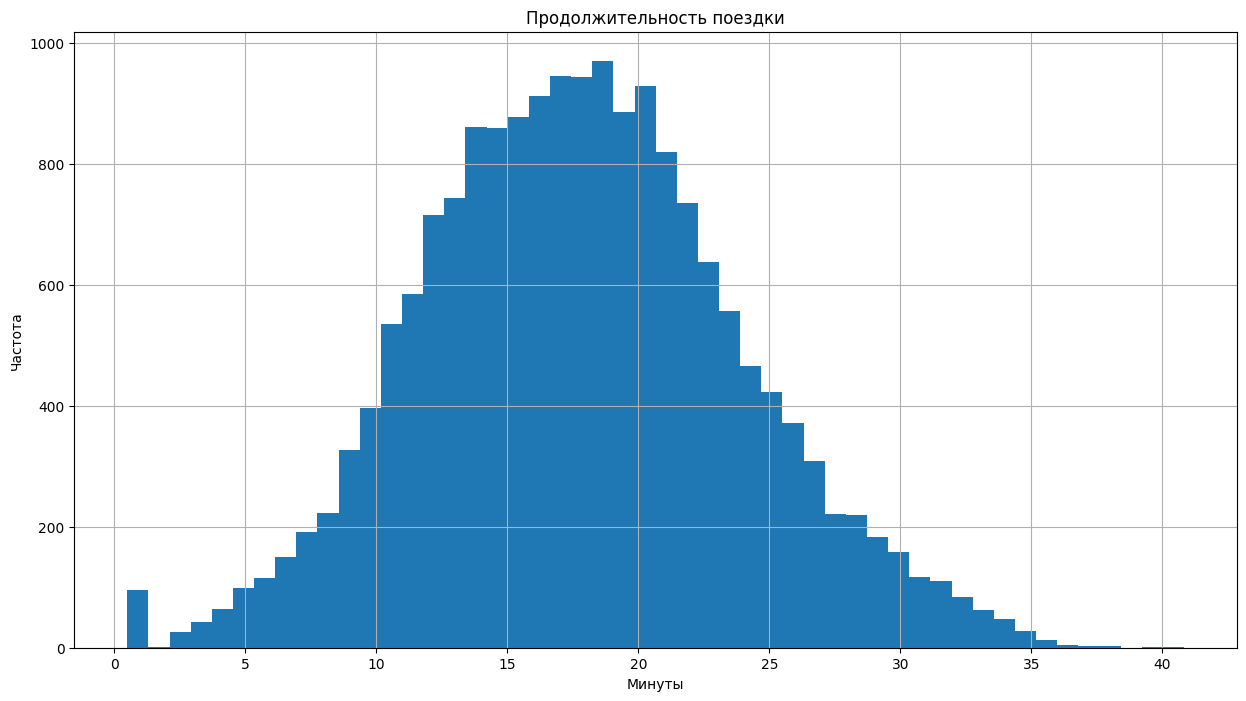

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [23]:
rides_go['duration'].plot(
    kind = 'hist',
    bins=50,
    figsize=(15, 8),
    grid=True
)

plt.title('Продолжительность поездки')
plt.xlabel('Минуты')
plt.ylabel('Частота')

# Показать график
plt.show()

rides_go['duration'].describe()

Данные распределены нормально, значения варьируются от 0,5 до ~41 минуты. Поездки длиной в 30 секунд могут быть осмысленными, например, как проверки самоката.

**Промежуточный итог по данным сервиса:**

- В Пятигорске наибольшее количество пользователей — 219;
- Пользователей с подпиской **free** на 8,8% больше: без подписки — 835 человек, с подпиской — 699;
- Наиболее популярная возрастная группа — 25 лет;
- За одну поездку пользователи преодолевают расстояния от 1 до 7211 метров. Мода пиков — примерно 750 и 3200 метров;
- Продолжительность поездок варьируется от 0,5 до 41 минуты

## Объединение данных

**Объедините данные о пользователях, поездках и подписках в один датафрейм**

In [24]:
# Проверим размеры датафреймов
print(f'Размер датафрейма users_go: {users_go.shape[0]} строки, {users_go.shape[1]} столбцов')
print(f'Размер датафрейма rides_go: {rides_go.shape[0]} строки, {rides_go.shape[1]} столбцов')
print(f'Размер датафрейма subscriptions_go: {subscriptions_go.shape[0]} строки, {subscriptions_go.shape[1]} столбцов')

Размер датафрейма users_go: 1534 строки, 5 столбцов
Размер датафрейма rides_go: 18068 строки, 5 столбцов
Размер датафрейма subscriptions_go: 2 строки, 4 столбцов


Сначала объединим два датафрейма `user_go` и `rides_go` с помощью метода `merge()` по столбцу `user_id`, а затем добавим датафрейм `subscriptions_go`, объединив его по столбцу `subscription_type`

In [25]:
df = users_go.merge(rides_go, on='user_id').merge(subscriptions_go, on='subscription_type')
display(df.head(10))
df.tail(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
18058,1534,Альберт,25,Краснодар,free,195.447469,6.469074,2021-06-11,6,8,50,0
18059,1534,Альберт,25,Краснодар,free,3214.021065,18.343604,2021-06-18,6,8,50,0
18060,1534,Альберт,25,Краснодар,free,3644.708038,20.289416,2021-08-08,8,8,50,0
18061,1534,Альберт,25,Краснодар,free,3977.744996,26.916544,2021-08-20,8,8,50,0
18062,1534,Альберт,25,Краснодар,free,4928.173852,22.560373,2021-09-13,9,8,50,0
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0
18067,1534,Альберт,25,Краснодар,free,2371.711192,15.893917,2021-12-29,12,8,50,0


In [26]:
# Проверим размер объединенного датафрейма
print(f'Размер датафрейма df: {df.shape[0]} строки, {df.shape[1]} столбцов')

Размер датафрейма df: 18068 строки, 12 столбцов


Все данные были объединены в один датафрейм, и итоговое количество столбцов соответствует ожидаемому результату

**Создайте ещё два датафрейма из датафрейма, созданного на этапе:**
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской

In [27]:
# Пользователи без подписки
df_unsubs = df.query('subscription_type == "free"')
df_unsubs.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


In [28]:
# Проверим размер датафрейма
print(f'Размер датафрейма df_unsubs: {df_unsubs.shape[0]} строки, {df_unsubs.shape[1]} столбцов')

Размер датафрейма df_unsubs: 11568 строки, 12 столбцов


In [29]:
# Пользователи c подпиской
df_subs = df.query('subscription_type == "ultra"')
df_subs.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [30]:
# Проверим размер датафрейма
print(f'Размер датафрейма df_subs: {df_subs.shape[0]} строки, {df_subs.shape[1]} столбцов')

Размер датафрейма df_subs: 6500 строки, 12 столбцов


Данные разделены по категориям, с подпиской и без!

**Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий**

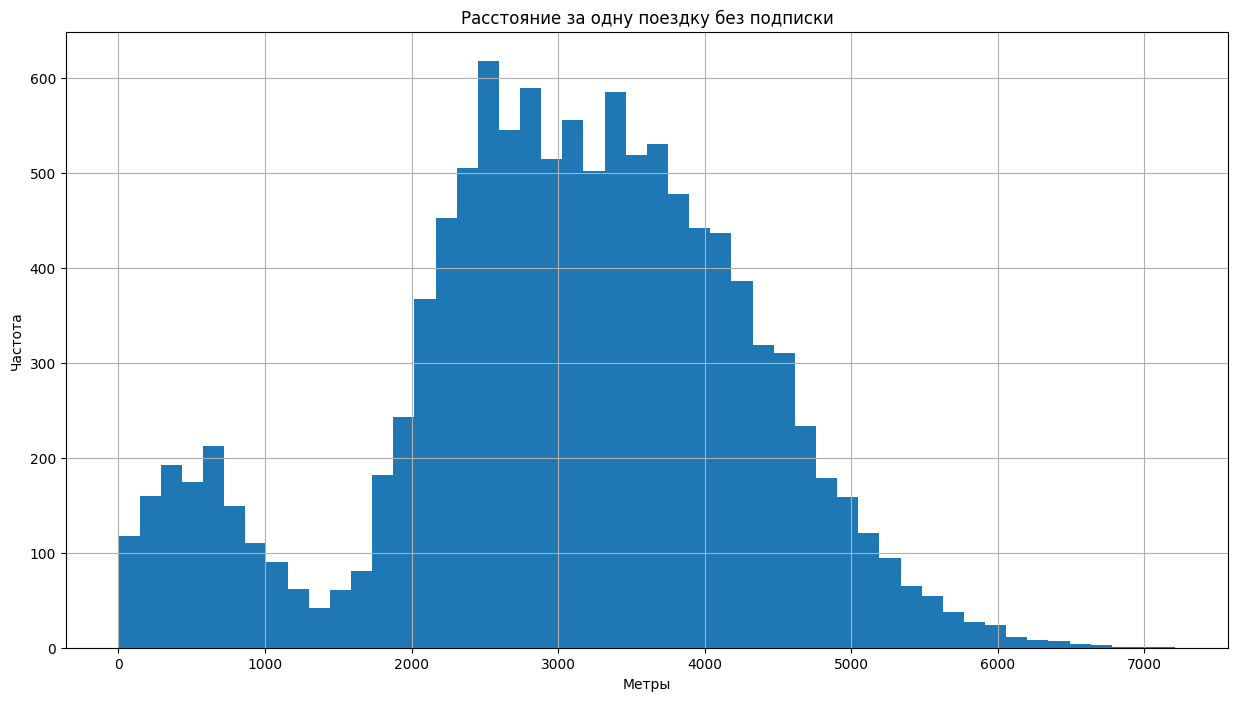

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

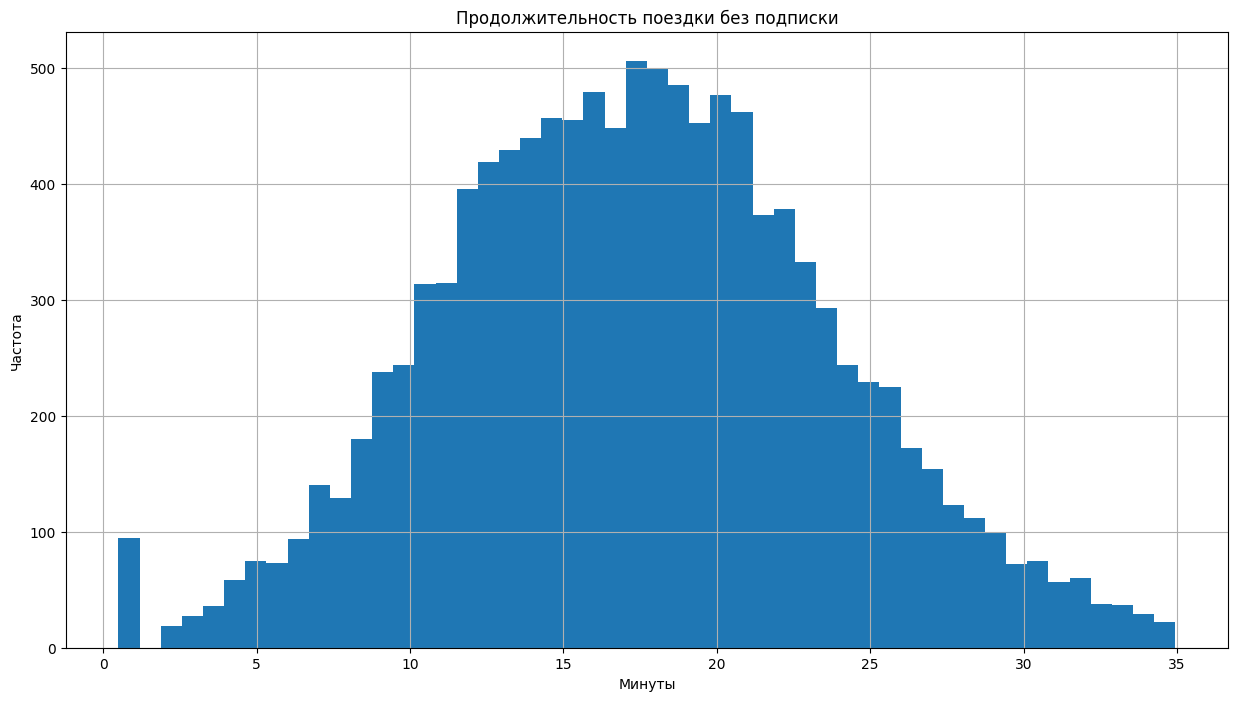

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [31]:
df_unsubs['distance'].plot(
    kind = 'hist',
    bins=50,
    figsize=(15, 8),
    grid=True
)

plt.title('Расстояние за одну поездку без подписки')
plt.xlabel('Метры')
plt.ylabel('Частота')

# Показать график
plt.show()

display(df_unsubs['distance'].describe())

df_unsubs['duration'].plot(
    kind = 'hist',
    bins=50,
    figsize=(15, 8),
    grid=True
)

plt.title('Продолжительность поездки без подписки')
plt.xlabel('Минуты')
plt.ylabel('Частота')

# Показать график
plt.show()

df_unsubs['duration'].describe()

На графике преодолённого расстояния видны два выраженных пика: первый — в диапазоне от ~0 до ~1400 метров, второй — от ~1400 до ~7211 метров. Время поездки у пользователей с подпиской варьируется от 30 секунд до 35 минут

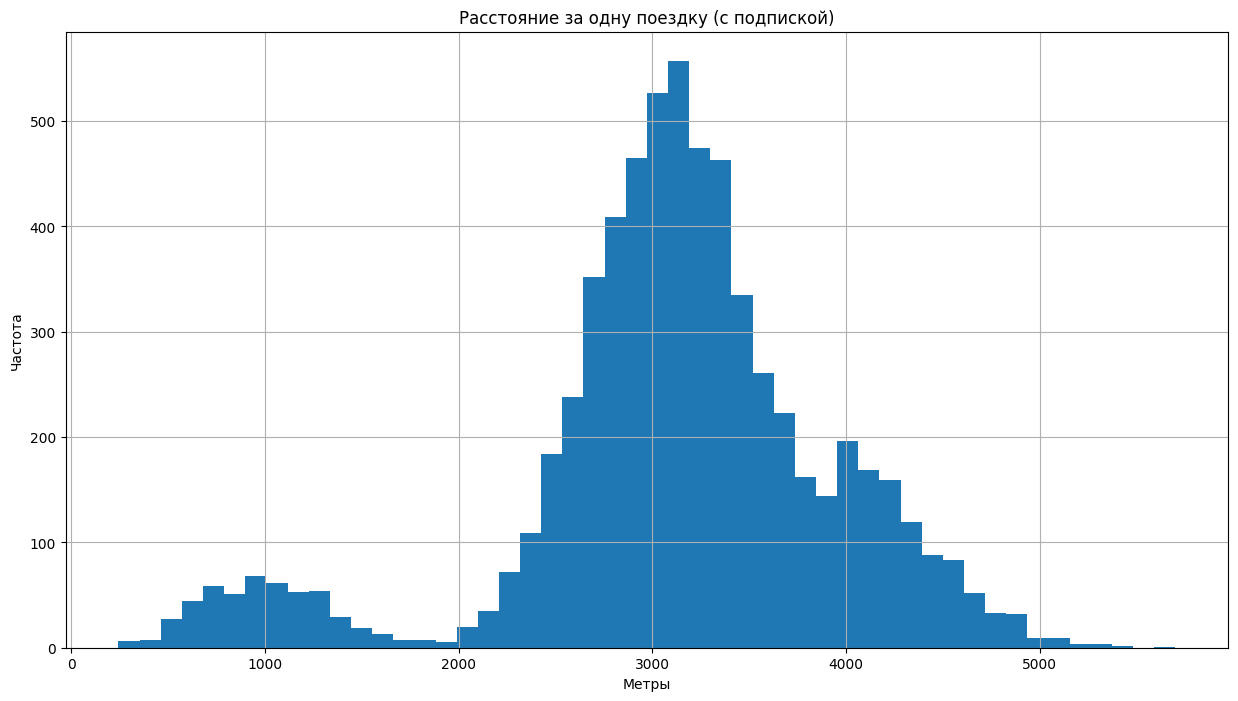

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

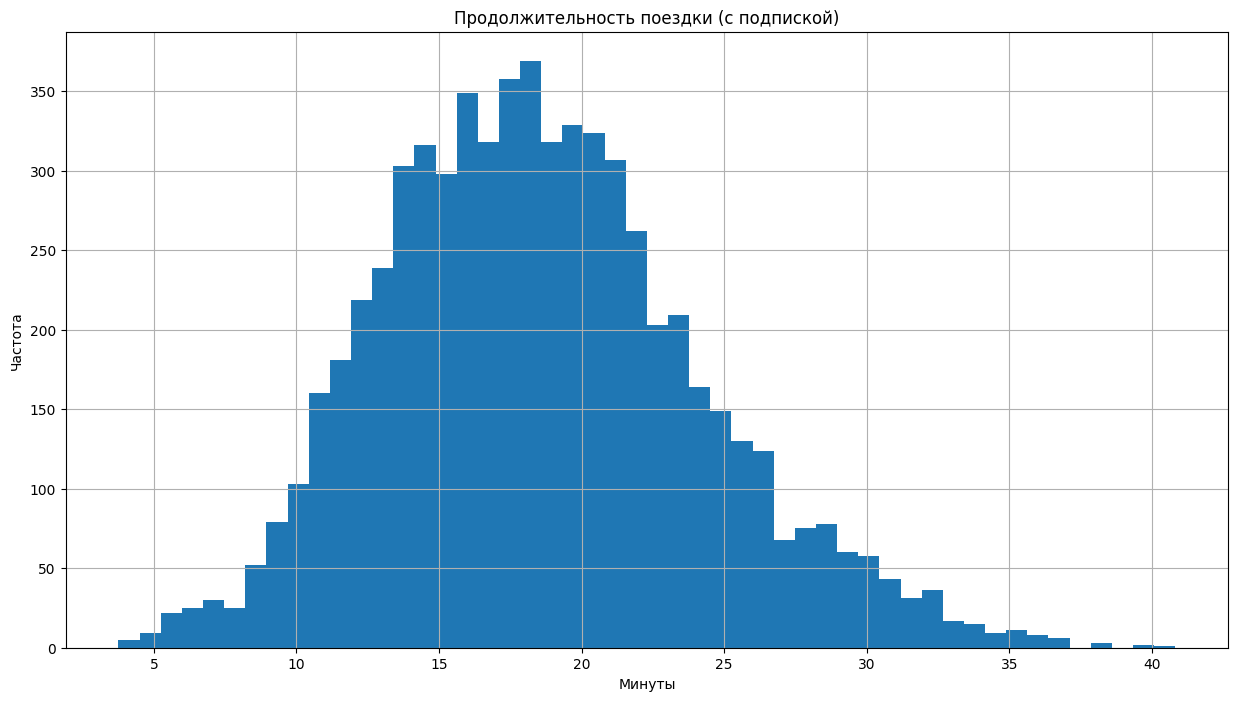

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [32]:
df_subs['distance'].plot(
    kind = 'hist',
    bins=50,
    figsize=(15, 8),
    grid=True
)

plt.title('Расстояние за одну поездку (c подпиской)')
plt.xlabel('Метры')
plt.ylabel('Частота')

# Показать график
plt.show()

display(df_subs['distance'].describe())

df_subs['duration'].plot(
    kind = 'hist',
    bins=50,
    figsize=(15, 8),
    grid=True
)

plt.title('Продолжительность поездки (c подпиской)')
plt.xlabel('Минуты')
plt.ylabel('Частота')

# Показать график
plt.show()

df_subs['duration'].describe()

На графике преодолённого расстояния видны два выраженных пика: первый — в диапазоне от ~250 до ~1650 метров, второй — от ~1650 до 5700 метров. Время поездки у пользователей с подпиской варьируется от ~3 до 35 минут

**Промежуточный итог по данным сервиса:**

- Были объедены датафреймы, в один общий df;
- Пользователей сервиса были поделены на группы с подпиской и без; 
- По построенным диаграммам определено:
    - Пользователи без подписки в целом преодолевают на самокате больше расстояния, от ~0 до ~1400 метров и от ~1400 до ~7211 метров; 
    - Время поездки у пользователей с подпиской варьируется от 30 секунд до 35 минут;
    - Пользователи с подпиской преодолевают расстояние, от ~250 до ~1650 на средней дистанции и от ~1650 до 5700 метров на длительной дистанции;
    - Время поездки у пользователей с подпиской варьируется от ~3 до 35 минут;
- Пользователи без подписки обычно совершают больше коротких поездок длиной до 1 километра, а максимальная дальность их поездок больше, чем у тех, кто пользуется подпиской

## Подсчёт выручки

**Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц**

Проверим на наличие пропусков в датафрейме df, после объединения данных

In [33]:
# Определим количество пропущенных значений в каждом столбце
df.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [34]:
# Округлим расстояние до "потолка" методом ceil()
df['distance'] = np.ceil(df['distance']).astype('int')
df['distance'].head()

0    4410
1    2618
2     755
3    2695
4    4029
Name: distance, dtype: int64

In [35]:
# Создадим сводную таблицу
total_agg = df.pivot_table(
    index=['user_id', 'month'],
    values=['distance', 'name', 'duration'],
    aggfunc={'distance': 'sum', 'name': 'count', 'duration': 'sum'}
)
total_agg.columns = ['total_distance', 'total_duration', 'number_of_rides']

# Обнулим индексы
total_agg = total_agg.reset_index()

total_agg['total_duration'] = np.ceil(total_agg['total_duration']).astype('int')
display(total_agg.head(10))
total_agg.info()

,user_id,month,total_distance,total_duration,number_of_rides
0,1,1,7028,42,2
1,1,4,755,7,1
2,1,8,6724,45,2
3,1,10,5811,32,2
4,1,11,7005,54,3
5,1,12,6753,28,2
6,2,3,10190,61,3
7,2,4,6165,40,2
8,2,6,3256,14,1
9,2,7,6781,47,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   user_id          11331 non-null  int64
 1   month            11331 non-null  int32
 2   total_distance   11331 non-null  int64
 3   total_duration   11331 non-null  int64
 4   number_of_rides  11331 non-null  int64
dtypes: int32(1), int64(4)
memory usage: 398.5 KB


Получили таблицу, которая позволяет анализировать поведение пользователей по месяцам, включая суммарное количество поездок, общее расстояние и время, проведенное в поездках

**В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь.**

Помесячная выручка считается по формуле: start_ride_price × number_of_rides + minute_price × total_duration + subscription_fee

In [36]:
# Создадим сводную таблицу
result_agg = df.pivot_table(
    index=['user_id', 'month'],
    values=['start_ride_price', 'minute_price', 'subscription_fee'],
)

result_agg = result_agg.reset_index()

print('До объединения')
display(result_agg.head())

result_agg = total_agg.merge(result_agg, on=['user_id', 'month'])
print('Полная сводная таблица')
display(result_agg)

До объединения


,user_id,month,minute_price,start_ride_price,subscription_fee
0,1,1,6.0,0.0,199.0
1,1,4,6.0,0.0,199.0
2,1,8,6.0,0.0,199.0
3,1,10,6.0,0.0,199.0
4,1,11,6.0,0.0,199.0


Полная сводная таблица


,user_id,month,total_distance,total_duration,number_of_rides,minute_price,start_ride_price,subscription_fee
0,1,1,7028,42,2,6.0,0.0,199.0
1,1,4,755,7,1,6.0,0.0,199.0
2,1,8,6724,45,2,6.0,0.0,199.0
3,1,10,5811,32,2,6.0,0.0,199.0
4,1,11,7005,54,3,6.0,0.0,199.0
...,...,...,...,...,...,...,...,...
11326,1534,6,3411,25,2,8.0,50.0,0.0
11327,1534,8,7623,48,2,8.0,50.0,0.0
11328,1534,9,4929,23,1,8.0,50.0,0.0
11329,1534,11,13353,77,4,8.0,50.0,0.0


In [37]:
# Определим количество пропущенных значений в каждом столбце
result_agg.isna().sum()

user_id             0
month               0
total_distance      0
total_duration      0
number_of_rides     0
minute_price        0
start_ride_price    0
subscription_fee    0
dtype: int64

In [38]:
# Помесячная выручка считается по формуле: start_ride_price × number_of_rides + minute_price × total_duration + subscription_fee

result_agg['profit'] = (result_agg['start_ride_price'] * result_agg['number_of_rides'] +
                      result_agg['minute_price'] * result_agg['total_duration'] +
                      result_agg['subscription_fee']
                     )

result_agg.head(10)

,user_id,month,total_distance,total_duration,number_of_rides,minute_price,start_ride_price,subscription_fee,profit
0,1,1,7028,42,2,6.0,0.0,199.0,451.0
1,1,4,755,7,1,6.0,0.0,199.0,241.0
2,1,8,6724,45,2,6.0,0.0,199.0,469.0
3,1,10,5811,32,2,6.0,0.0,199.0,391.0
4,1,11,7005,54,3,6.0,0.0,199.0,523.0
5,1,12,6753,28,2,6.0,0.0,199.0,367.0
6,2,3,10190,61,3,6.0,0.0,199.0,565.0
7,2,4,6165,40,2,6.0,0.0,199.0,439.0
8,2,6,3256,14,1,6.0,0.0,199.0,283.0
9,2,7,6781,47,2,6.0,0.0,199.0,481.0


Получили столбец `profit`, который содержит рассчитанную прибыль для каждого пользователя за месяц. Формула учитывает все доходы от числа поездок, времени в поездках и наличия подписки

## Проверка гипотез

**Задача, увеличить количество пользователей, для этого проверим гипотезы.**

### Тратят ли пользователи с подпиской больше времени на поездки?

Определим нулевую и альтернативную гипотезу:

 - H0: *Среднее время, проводимое в поездках пользователями с подпиской, равно среднему времени, проводимому пользователями без подписки*
 - H1: *Среднее время, проводимое в поездках пользователями с подпиской, больше среднего времени, проводимого пользователями без подписки*
 
H0 = H1
<br>H1 > H0

Для проверки равенства средних двух генеральных совокупностей используем метод `scipy.stats.ttest_ind`. Так же используем парметр `alternative='greater'`

Поскольку нет оснований полагать, что дисперсии генеральных совокупностей различны `(equal_var=Tue)`, и благодаря ЦПТ можно считать, что совокупности нормально распределены

In [39]:
# Определеим генеральные совокупности
df_subs_ttest = df_subs['duration']
df_unsubs_ttest = df_unsubs['duration']

alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(df_subs_ttest, df_unsubs_ttest, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


Вывод:

Результаты проверки гипотезы показывают, что p-значение значительно меньше уровня значимости alpha = 0,05. Это позволяет отвергнуть нулевую гипотезу.

Таким образом, можно сделать вывод, что среднее время, проводимое в поездках пользователями с подпиской, статистически значимо больше, чем у пользователей без подписки. Это подтверждает, что пользователи с подпиской могут быть более "выгодными" для компании, так как они тратят больше времени на поездки

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

### Какое расстояние проезжают пользователи с подпиской за одну поездку?

Определим нулевую и альтернативную гипотезу:

 - H0: *Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров*
 - H1: *Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, больше 3130 метров*
 
H0 = 3130
<br>H1 > H0

Какая гипотеза проверяется? - О равенстве среднего генеральной совокупности числу

Для проверки гипотезы используем метод `scipy.stats.ttest_1samp`. Так же используем парметр `alternative='less'`

In [40]:
df_subs_mean = df_subs['distance']
value = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(df_subs_mean, value, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Вывод:

Результаты проверки гипотезы показывают, что p-значение 0.919 больше уровня значимости α=0,05. Это означает, что не получилось отвергнуть нулевую гипотезу.

Таким образом, на основании данных нельзя сделать вывод о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров. Следовательно, можно считать, что среднее расстояние поездок пользователей с подпиской не превышает или равно 3130 метров

### Будет ли выручка от пользователей с подпиской больше, чем от обычных пользователей?

Определим нулевую и альтернативную гипотезу:

 - H0: *Помесячная выручка от пользователей с подпиской не выше, чем выручка от пользователей без подписки.*
 - H1: *Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.*
 
H0 < H1
<br>H1 > H0

Какая гипотеза проверяется? - О равенстве средних двух генеральных совокупностей.

Для проверки равенства средних двух генеральных совокупностей используем метод `scipy.stats.ttest_ind`. Так же используем парметр `alternative='greater'`

Поскольку нет оснований полагать, что дисперсии генеральных совокупностей различны `(equal_var=Tue)`, и благодаря ЦПТ можно считать, что совокупности нормально распределены

In [41]:
subs_profit = result_agg.query('subscription_fee == 199')['profit']  # выручка пользователей с подпиской
unsubs_profit = result_agg.query('subscription_fee == 0')['profit']  # выручка пользователей без подписки

alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(subs_profit, unsubs_profit, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


Вывод:

Результаты проверки гипотезы показывают, что p-значение значительно меньше уровня значимости alpha = 0,05. Это позволяет отвергнуть нулевую гипотезу.

Таким образом, можно сделать вывод, что помесячная выручка от пользователей с подпиской статистически значимо выше, чем выручка от пользователей без подписки. Это свидетельствует о том, что подписчики приносят больше дохода компании по сравнению с пользователями без подписки

**Промежуточный итог по данным сервиса:**

- **Время поездок**: Среднее время, проводимое в поездках пользователями с подпиской, статистически значимо больше, чем у пользователей без подписки. Это указывает на то, что подписчики могут быть более выгодны для компании, так как тратят больше времени на поездки;

- **Расстояние поездок**: На основании данных нельзя сделать вывод о том, что среднее расстояние поездок пользователей с подпиской меньше 3130 метров. Следовательно, можно считать, что среднее расстояние не превышает этого значения;

- **Помесячная выручка**: Помесячная выручка от пользователей с подпиской статистически значимо выше, чем выручка от пользователей без подписки, что свидетельствует о том, что подписчики приносят больше дохода компании;

- В целом пользователи с подпиской приносят больше дохода компании, делая их ценным для бизнеса

## Вывод

Исследование сервиса аренды самокатов GoFast проведено с целью анализа данных о пользователях и их поездках для повышения выручки и оптимизации бизнес-процессов. В проекте были выполнены следующие основные шаги:

##### Предобработка данных:
1. **Обработка пропусков и аномалий**:
   - Все данные были проверены на наличие пропусков, а также на аномалии и дубликаты, которые были обработаны для получения корректного датафрейма.
   
2. **Изменение типов данных**:
   - Типы данных были преобразованы для дальнейшего анализа, в том числе формат времени был изменен на тип `datetime`, а числовые значения округлены для удобства.

##### Исследовательский анализ данных:
1. **Города и подписки**:
   - Наибольшее количество пользователей из Пятигорска, а пользователей без подписки оказалось больше на 8,8%, чем с подпиской.
   
2. **Возраст пользователей**:
   - Наиболее популярная возрастная группа — 25 лет, что указывает на активное использование сервиса среди молодежи.

3. **Анализ поездок**:
   - Основная часть поездок занимает от 2500 до 3800 метров. Медиана 3133 метра. Поездки на расстояние более 5 км редки. Однако на гистограмме видно, что некоторая часть пользователей использует самокаты для коротких поездок - до 1500 м. Продолжительность поездки — от 0,5 до 41 минуты. Пользователи с подпиской преодолевают более длинные дистанции и проводят больше времени в поездках.

##### Проверка гипотез:
1. **Траты времени на поездки**:
   - Было доказано, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. Это указывает на важность подписок для увеличения общей выручки.

2. **Оптимальное расстояние поездок**:
   - Не удалось доказать, что среднее расстояние поездок пользователей с подпиской меньше 3130 метров, что свидетельствует о стабильности среднего расстояния.

3. **Выручка от подписок**:
   - Выручка от пользователей с подпиской оказалась статистически значимо выше, чем у пользователей без подписки, что подтверждает финансовую выгоду подписной модели для бизнеса.

##### Заключение:
Результаты исследования показали, что пользователи с подпиской более активны и приносят больше выручки, чем пользователи без подписки. Это позволяет сервису сосредоточиться на привлечении и удержании подписчиков для дальнейшего роста.